In [86]:
import pandas as pd 
import numpy as np
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from arch import arch_model
%matplotlib inline

/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#helper function to make sense of excel serial date format
import datetime

def xldate_to_datetime(xldate):
    temp = datetime.datetime(1900, 1, 1)
    delta = datetime.timedelta(days=xldate)
    return temp+delta

In [ ]:
How much of return/loss happens on days when prices move drastically? 
The question really is since it matters if you are exposed to large price movements, can we predict those movements. 
The next question is can we use volatility in forward returns to predict volatility in returns further out?
Can volatility patterns predict volatility?

In [31]:
def evaluate_model(predictions,returns):
    '''
    
    '''
    comparison = pd.DataFrame()
    comparison['returns'] = returns
    comparison['prediction'] = predictions
    comparison['strategy'] = comparison['prediction'] * comparison['returns']
    
    return comparison 

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#model imports 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from sklearn.model_selection import TimeSeriesSplit

classifiers = [
    LogisticRegression(),
#     KNeighborsClassifier(6),
#     SVC(kernel="rbf", C=0.025, probability=True),
#     RandomForestClassifier(),
#     AdaBoostClassifier(),
#     GradientBoostingClassifier(),
#     BernoulliNB(),
#     LinearDiscriminantAnalysis(),
    ]

# Logging for Visual Comparison
log_cols=["Classifier", "Fold", "Accuracy", "Precision", "Recall", "F1"]
log = pd.DataFrame(columns=log_cols)

#todo
#for day in ["tail_21"]:
model_test_period_returns = {}
    
for clf in classifiers:

    tscv = TimeSeriesSplit(n_splits=10)
    fold = 1
    for train_index, test_index in tscv.split(features):
        #print(test_index)
        X_train = features[:train_index[-1]]
        y_train = targets[:train_index[-1]]
        X_test = features[train_index[-1]:]
        y_test = targets[train_index[-1]:]



        clf.fit(X_train, y_train)
        name = clf.__class__.__name__

        test_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test.values, test_predictions)


        precision = precision_score(y_test.values, test_predictions, average='micro')
        recall = recall_score(y_test.values, test_predictions, average='micro')
        f1 = f1_score(y_test.values, test_predictions, average='micro')



        log_entry = pd.DataFrame([[name, fold, acc*100, precision, recall, f1]], columns=log_cols)
        log_entry = log_entry.set_index(keys='Classifier')
        log = log.append(log_entry)
        fold += 1
    model_test_period_returns[str(name) + ] = evaluate_model(test_predictions, returns[train_index[-1]:])

log = log.dropna(axis=1)


In [79]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [80]:
returns = pd.read_csv('/Users/livingdharma/Downloads/ProgrammingTest/SpxFwdPct_Data.csv')
returns['date'] = returns['Lookup'].apply(xldate_to_datetime)
returns = returns.drop('Lookup', axis=1)
returns = returns.set_index('date')

In [99]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.2f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl
TS = lrets
res_tup = _get_best_model(returns['3'])

/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/livingdharma/miniconda2/envs/xarray-dev/lib/pyth

aic: -135067.84 | order: (2, 0, 2)


/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [100]:
order = res_tup[1]
model = res_tup[2]

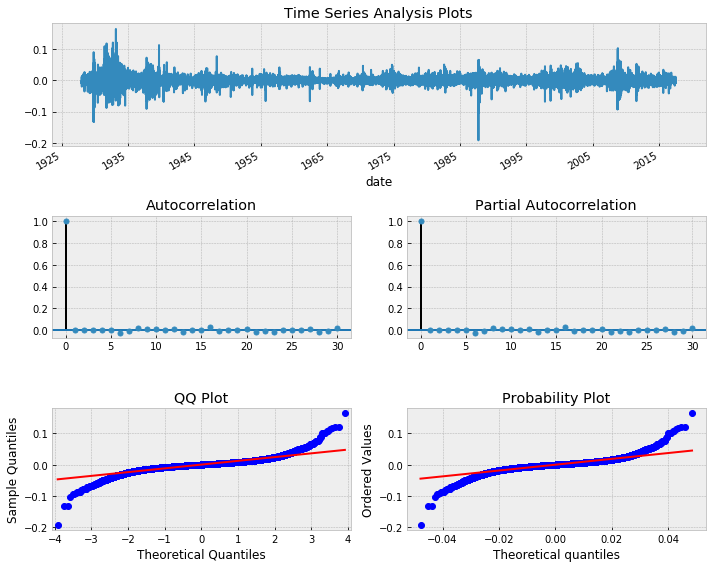

In [101]:
tsplot(model.resid, lags=30)

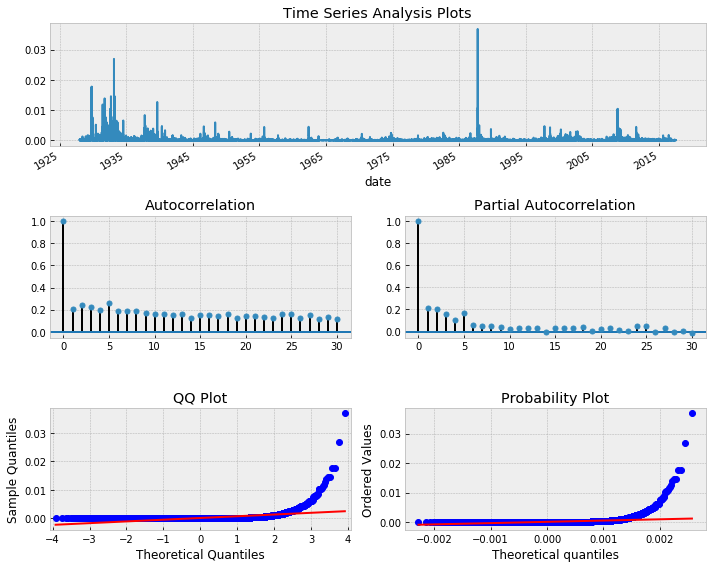

In [102]:
tsplot(model.resid**2, lags=30)

In [103]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                      -2.594
Mean Model:                   Constant Mean   Adj. R-squared:                 -2.594
Vol Model:                            GARCH   Log-Likelihood:                50688.0
Distribution:      Standardized Student's t   AIC:                          -101362.
Method:                  Maximum Likelihood   BIC:                          -101306.
                                              No. Observations:                22489
Date:                      Sun, Jun 03 2018   Df Residuals:                    22482
Time:                              17:47:19   Df Model:                            7
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


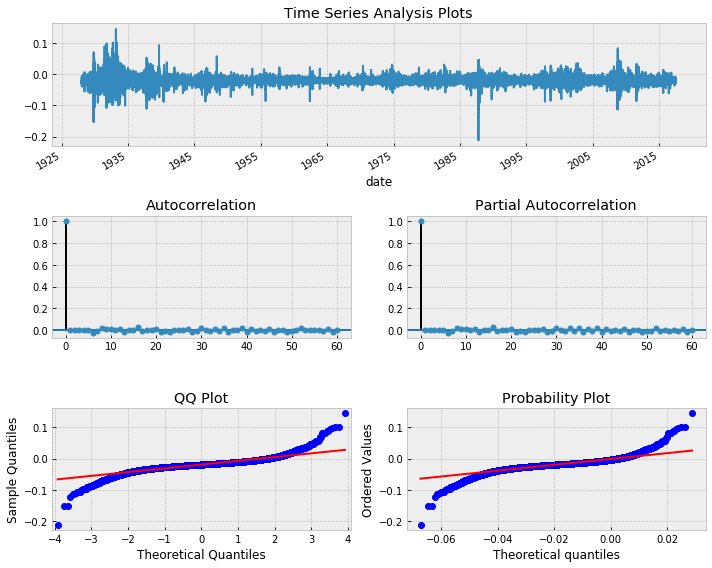

In [104]:
tsplot(res.resid, lags=60)

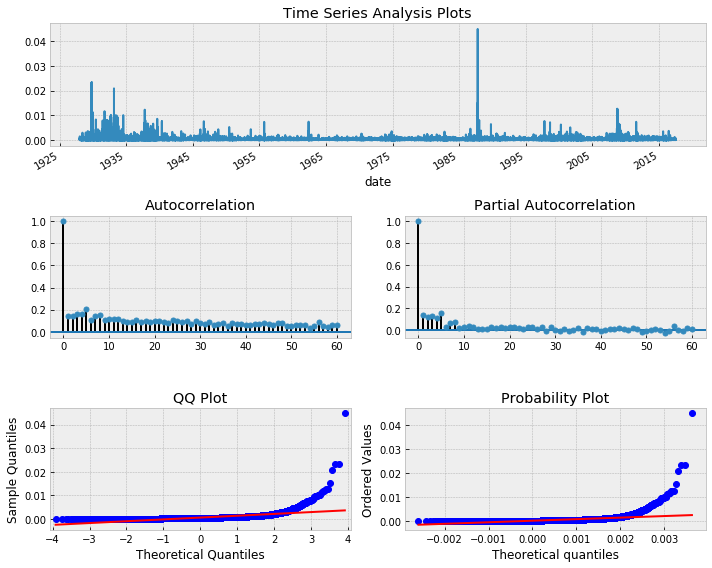

In [105]:
tsplot(res.resid**2, lags=60)

In [106]:
lrets = returns['10']
windowLength = 252//10
foreLength = len(lrets) - window
signal = 0*lrets[-foreLength:]
#returns['3']

In [107]:
for d in range(foreLength):
    
    # create a rolling window by selecting 
    # values between d+1 and d+T of S&P500 returns
    
    TS = lrets[(1+d):(windowLength+d)] 
    
    # Find the best ARIMA fit 
    # set d = 0 since we've already taken log return of the series
    res_tup = _get_best_model(TS)
    order = res_tup[1]
    model = res_tup[2]
    
    #now that we have our ARIMA fit, we feed this to GARCH model
    p_ = order[0]
    o_ = order[1]
    q_ = order[2]
    
    am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
    res = am.fit(update_freq=5, disp='off')
    
    # Generate a forecast of next day return using our fitted model
    out = res.forecast(horizon=1, start=None, align='origin')
    
    #Set trading signal equal to the sign of forecasted return
    # Buy if we expect positive returns, sell if negative
      
    signal.iloc[d] = np.sign(out.mean['h.1'].iloc[-1])

/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packa

aic: -152.51 | order: (0, 0, 2)


/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ValueError: One of p or o must be strictly positive